In [ ]:
"""
input:
    - authorid_date_anti_pro.parquet
    - authorid_date_sentiment.parquet
output:
    - tweet_count_of_authors.svg
    - num_of_users_and_posted_tweets_pos_neg_percentage.svg
    - positive_negative_hexbin_plot_strached.svg
    - histplot_of_positive_percentages_for_all_users.pdf
    - label_change_of_users_who_sent_2_tweets.parquet
    - label_change_of_users_who_sent_2_tweets.xlsx
"""

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
data_path = "/data/raw/world_data"
supp_figures_path = "/figures/experimental/supp_figures"
main_figures_path = "/figures/experimental/main_figures"
dataframes_path = "/data/processed/dataframes"
sentiments_path = "/data/processed/sentiment_analysis/all_world"

In [3]:
authorid_date_anti_pro = pd.read_parquet(f"{dataframes_path}/authorid_date_anti_pro.parquet")

In [5]:
greather_than_99 = np.max(authorid_date_anti_pro[['Anti', "Pro"]].values, axis=1) >= 0.99

authorid_date_anti_pro = authorid_date_anti_pro.iloc[greather_than_99, :]
author_id_tweet_count = authorid_date_anti_pro.value_counts('author_id').reset_index(name='tweet_count')
tweetcount_numOfAuthor = author_id_tweet_count.value_counts('tweet_count').reset_index(name='number_of_author')

In [6]:
tweetcount_numOfAuthor = tweetcount_numOfAuthor.sort_values('tweet_count')
lt_20 = tweetcount_numOfAuthor[tweetcount_numOfAuthor['tweet_count'] < 20]
gt_20 = tweetcount_numOfAuthor[tweetcount_numOfAuthor['tweet_count'] >= 20]

In [ ]:
twenty_plus = gt_20['number_of_author'].sum()
lt_20['tweet_count'] = lt_20['tweet_count'].astype('str')
lt_20 = lt_20.append(pd.DataFrame([['20+', twenty_plus]], columns=lt_20.columns), ignore_index=True)

lt_20_cumsum = lt_20.copy(deep=True)
lt_20_cumsum['number_of_author'] = lt_20_cumsum['number_of_author'].cumsum()

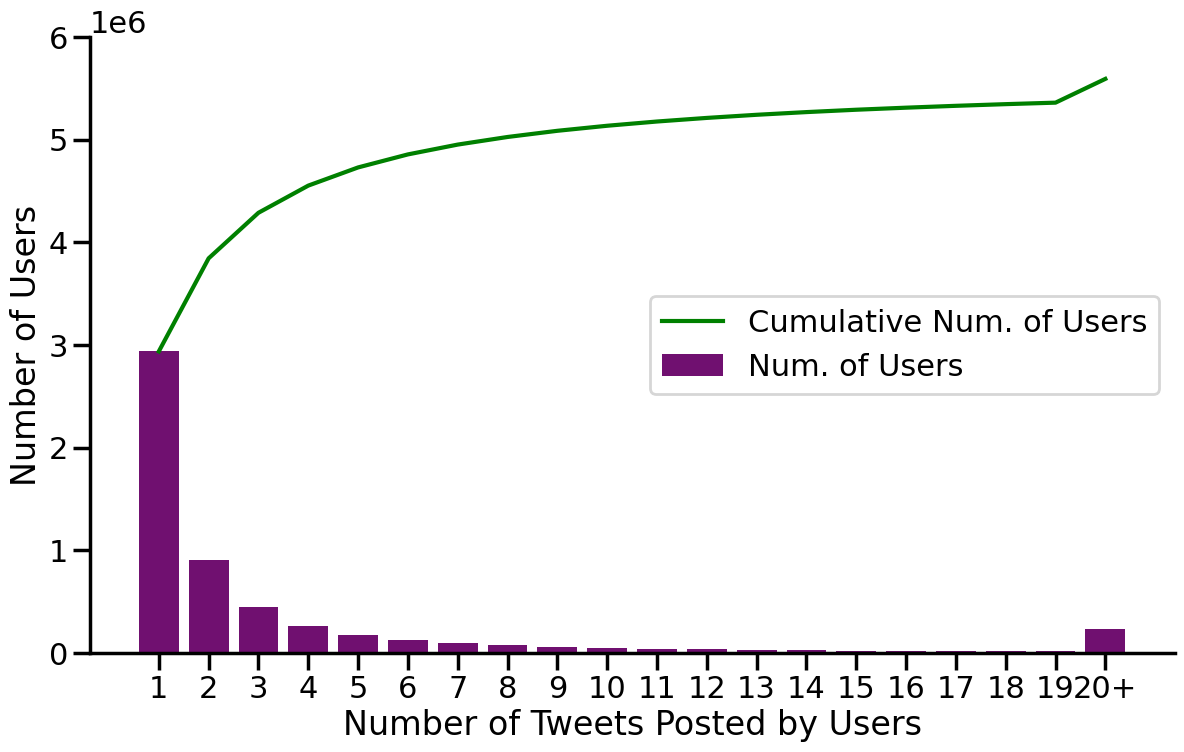

In [8]:
sns.set_context('poster', 1)
fig, ax = plt.subplots(figsize=(14, 8))

sns.barplot(data=lt_20, x='tweet_count', y='number_of_author', ax=ax, color='purple', label='Num. of Users')

ax.set_xlabel('Number of Tweets Posted by Users')
ax.set_ylabel('Number of Users')

sns.lineplot(data=lt_20_cumsum, x='tweet_count', y='number_of_author', ax=ax, color='green', label='Cumulative Num. of Users')
sns.despine()

a_million = 1000000
plt.yticks(np.arange(0, max(lt_20_cumsum['number_of_author'].values)+a_million, a_million))
plt.legend(loc='center right')

plt.savefig(f'{supp_figures_path}/tweet_count_of_authors.svg', bbox_inches='tight')

# Positive Negative

In [9]:
authorid_date_sentiment = pd.read_parquet(f"{dataframes_path}/authorid_date_sentiment.parquet")
counts = authorid_date_sentiment.value_counts(['author_id', 'sentiment_label']).reset_index(name='counts')

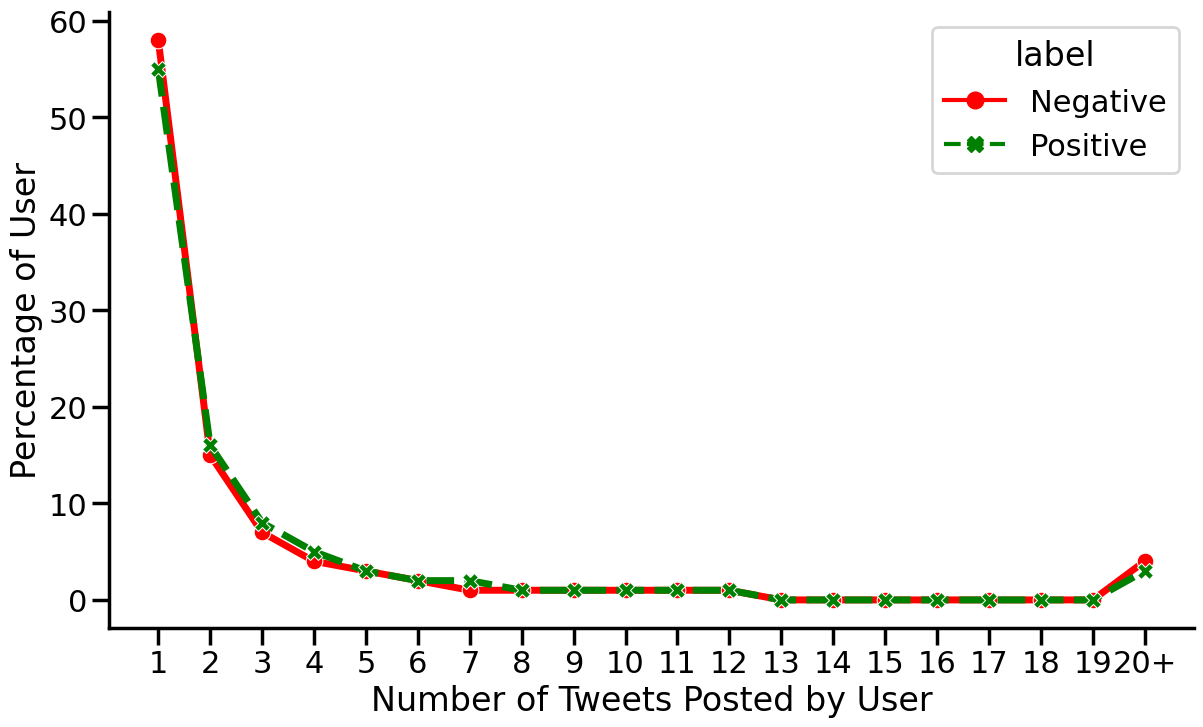

In [10]:
sns.set_context('poster', 1)

k = 19
plt.figure(figsize=(14, 8))

hist0, bin_edges0 = np.histogram(counts.loc[(counts['sentiment_label'] == 0) & (counts['counts'] <= k), 'counts'].values, bins=k)
hist1, bin_edges1 = np.histogram(counts.loc[(counts['sentiment_label'] == 1) & (counts['counts'] <= k), 'counts'].values, bins=k)

hist021plus, bin_edges021plus = np.histogram(counts.loc[(counts['sentiment_label'] == 0) & (counts['counts'] > k), 'counts'].values)
hist121plus, bin_edges121plus = np.histogram(counts.loc[(counts['sentiment_label'] == 1) & (counts['counts'] > k), 'counts'].values)

hist0_combined = np.array(hist0.tolist() + [np.sum(hist021plus)])
hist1_combined = np.array(hist1.tolist() + [np.sum(hist121plus)])

hist0_combined = hist0_combined / hist0_combined.sum()
hist1_combined = hist1_combined / hist1_combined.sum()

sentiments = np.concatenate([hist0_combined, hist1_combined])

hist_df = pd.DataFrame({'sentiment': np.round(sentiments * 100), 'label': ['Negative'] * (k+1) + ['Positive'] * (k+1), 'x_axis':(np.array(list(range(1, k+1))).astype(str).tolist() + [f'{k+1}+']) * 2})

sns.lineplot(data=hist_df, y='sentiment', x='x_axis', hue='label', palette=['r', 'g'], linewidth=5, style="label", markers=True)
plt.xlabel('Number of Tweets Posted by User')
plt.ylabel('Percentage of User')

plt.yticks(np.arange(0, max(hist_df['sentiment'].values)*1.1, 10))
sns.despine()

plt.savefig(f'{supp_figures_path}/num_of_users_and_posted_tweets_pos_neg_percentage.svg', bbox_inches='tight')

# Density Based Scatter Plot

In [11]:
counts_pivot = counts.pivot_table(index='author_id', columns='sentiment_label', values='counts', dropna=False)
counts_pivot = counts_pivot.fillna(0)
counts_pivot.columns = ['Negative', 'Positive']

agg_counts = counts_pivot.dropna()
agg_counts.loc[:, 'Positive'] = agg_counts['Positive'].values + 1
agg_counts.loc[:, 'Negative'] = agg_counts['Negative'].values + 1

In [12]:
import holoviews as hv
hv.extension("bokeh")

Output hidden; open in https://colab.research.google.com to view.

In [13]:
from matplotlib.colors import LinearSegmentedColormap
colormap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['white', 'orange', 'red']
)

In [14]:
agg_subset_reverse = agg_counts[(agg_counts['Negative'] >= 1000) | (agg_counts['Positive'] >= 1000)]

<ipython-input-15-144e4e4a5006>:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 30000)
<ipython-input-15-144e4e4a5006>:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 30000)
<ipython-input-15-144e4e4a5006>:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


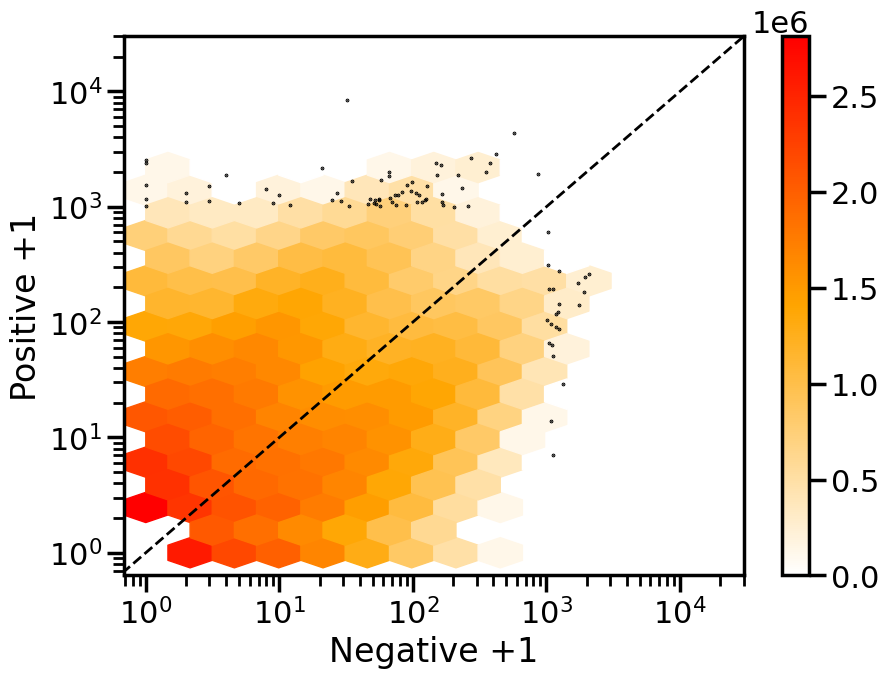

In [15]:
sns.set_context('poster')
plt.figure(figsize=(10, 7))
ax_hex = plt.hexbin(agg_counts['Negative'], agg_counts['Positive'], gridsize=(10, 10), cmap=colormap, bins='log', xscale='log', yscale='log')
ax = plt.scatter(agg_subset_reverse['Negative'], agg_subset_reverse['Positive'], s=0.5, color='black')
plt.xlim(0, 30000)
plt.ylim(0, 30000)

plt.plot([0,30000], [0,30000], color='black', linestyle='--', linewidth=2)
plt.xlabel('Negative +1')
plt.ylabel('Positive +1')

sm = plt.cm.ScalarMappable(cmap=colormap)
sm.set_array(ax_hex.get_array())
plt.colorbar(sm)
plt.savefig(f'{main_figures_path}/positive_negative_hexbin_plot_strached.svg', bbox_inches='tight')

## Positive Percentages of All Users

In [16]:
authorid_date_sentiment = pd.read_parquet(f"{dataframes_path}/authorid_date_sentiment.parquet")
counts = authorid_date_sentiment.value_counts(['author_id', 'sentiment_label']).reset_index(name='counts')

In [19]:
authors_has_single_tweet = counts.groupby('author_id').agg({'counts':'sum'}).reset_index()
filter_ = authors_has_single_tweet['counts'] == 1
authors_has_single_tweet = authors_has_single_tweet[filter_]['author_id'].values

In [20]:
filtered_counts = counts[~counts['author_id'].isin(authors_has_single_tweet)].reset_index(drop=True)
filtered_counts = filtered_counts.pivot_table(values='counts', index='author_id', columns='sentiment_label').reset_index()
filtered_counts = filtered_counts.fillna(0)
filtered_counts['positive_ratio'] = filtered_counts[1].values / filtered_counts[[0, 1]].sum(axis=1).values

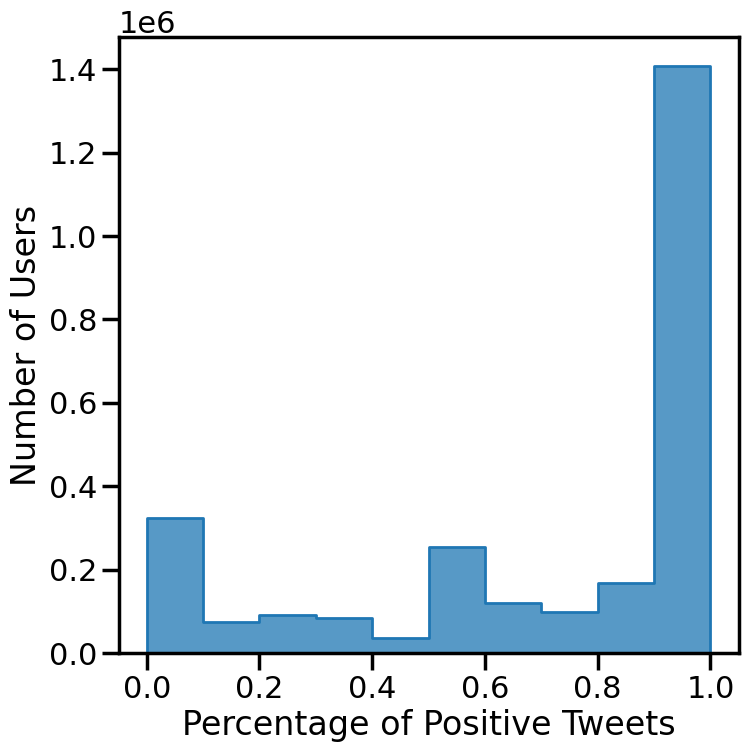

In [21]:
sns.set_context('poster', font_scale=1)

fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(data=filtered_counts, x="positive_ratio", bins=10, element='step', ax=ax)
ax.set_ylabel('Number of Users')
ax.set_xlabel('Percentage of Positive Tweets')

plt.savefig(f'{supp_figures_path}/histplot_of_positive_percentages_for_all_users.pdf', bbox_inches='tight')

## user sentiment change ratio within 2 tweets

- pos - pos
- pos - neg
- neg - neg
- neg - pos

In [ ]:
authorid_date_sentiment = pd.read_parquet(f"{dataframes_path}/authorid_date_sentiment.parquet")
counts = authorid_date_sentiment.value_counts(['author_id', 'sentiment_label']).reset_index(name='counts')

In [ ]:
authors_has_two_tweet = counts.groupby('author_id').agg({'counts':'sum'}).reset_index()
filter_ = authors_has_two_tweet['counts'] == 2
authors_has_two_tweet = authors_has_two_tweet[filter_]['author_id'].values

In [ ]:
authorid_date_sentiment['created_at'] = pd.to_datetime(authorid_date_sentiment['created_at'])

filter_ = authorid_date_sentiment['author_id'].isin(authors_has_two_tweet)
authorid_date_sentiment_only_2_tweets = authorid_date_sentiment[filter_].sort_values('created_at').reset_index(drop=True)

In [ ]:
authorid_date_sentiment_only_2_tweets.columns

Index(['author_id', 'created_at', 'sentiment_label'], dtype='object')

In [ ]:
changes_df = {}

for idx, arow in tqdm(authorid_date_sentiment_only_2_tweets.iterrows()):
    is_exist = changes_df.get(arow['author_id'], False)
    if is_exist is not False:
        changes_df[arow['author_id']] = is_exist + f" -> {arow['sentiment_label']}"
    else:
        changes_df[arow['author_id']] = str(arow['sentiment_label'])

changes_df = changes_df.items()
changes_df = pd.DataFrame(changes_df, columns=['author_id', 'label_change'])

1812860it [01:41, 17912.59it/s]


In [ ]:
changes_df.to_parquet(f"{dataframes_path}/label_change_of_users_who_sent_2_tweets.parquet", index=False)

In [ ]:
n_of_authors = changes_df.shape[0]
n_of_changes_df = changes_df.value_counts('label_change').reset_index(name='counts')
n_of_changes_df['ratio'] = n_of_changes_df['counts'].values / n_of_authors

In [ ]:
table_saving_path = "/data/tables"
n_of_changes_df.to_excel(f"{table_saving_path}/label_change_of_users_who_sent_2_tweets.xlsx", index=False)

In [ ]:
n_of_changes_df

,label_change,counts,ratio
0,1 -> 1,588485,0.649234
1,0 -> 0,142198,0.156877
2,0 -> 1,94163,0.103883
3,1 -> 0,81584,0.090006
